In [1]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from mlresearch.utils import set_matplotlib_style
from recgame.environments import CDAEnvironment
from recgame.recourse import DiCE

set_matplotlib_style(16)

# Some variables to define the problem
BIAS_FACTOR = 0
RNG_SEED = None
rng = np.random.default_rng(RNG_SEED)
N_CONTINUOUS = 2
N_AGENTS = 100

# NOTE: Categorical feature will be the "groups" variable; immutable + categorical

# Environment variables
N_LOANS = 10
ADAPTATION = .8
NEW_AGENTS = 10

# Define functions

In [2]:
def get_scaler(n_agents=10_000, n_continuous=2, bias_factor=0, random_state=None):
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]
    
    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=0, scale=1/2, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=bias_factor, scale=1/2, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    return MinMaxScaler().fit(X)


In [3]:
scaler = get_scaler(
    n_agents=10_000, 
    n_continuous=N_CONTINUOUS, 
    bias_factor=BIAS_FACTOR, 
    random_state=rng
)

In [4]:
def biased_data_generator(n_agents, n_continuous=2, bias_factor=0, scaler=None, random_state=None):
    """
    groups feature: 
    - 0 -> Disadvantaged group
    - 1 -> Advantaged group
    
    ``bias_factor`` varies between [0, 1], 0 is completely unbiased, 1 is fully biased.
    """
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]

    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=0, scale=3/4, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=bias_factor, scale=3/4, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    
    # TEST: scale continuous features
    if scaler is not None:
        X.loc[:,:] = scaler.transform(X)
    
    X = pd.concat([X, groups], axis=1)
    X = np.clip(X, 0, 1)
    
    # Generate the target
    p1 = 0.5 * bias_factor + 0.5
    p0 = 1 - p1

    y0 = rng.binomial(1, p0, counts[0])
    y1 = rng.binomial(1, p1, counts[1])
    
    y = pd.concat(
        [
            pd.Series((y0 if val==0 else y1), index=group.index) 
            for val, group in X.groupby("groups")
        ]
    ).sort_index()

    return X, y

In [5]:
def env_biased_data_generator(n_agents):
    return biased_data_generator(n_agents, N_CONTINUOUS, BIAS_FACTOR, scaler, rng)[0]

In [6]:
class IgnoreGroupLR(LogisticRegression):
    def __init__(self, ignore_feature=None, **kwargs):
        super().__init__(**kwargs)
        self.ignore_feature = ignore_feature
    
    def _get_X(self, X):
        return X.copy() if self.ignore_feature is None else X.drop(columns=self.ignore_feature)
    
    def fit(self, X, y):
        """NOTE: X must be a pandas dataframe."""
        super().fit(self._get_X(X), y)
        return self

    def predict(self, X):
        return super().predict(self._get_X(X))
    
    def predict_proba(self, X):
        return super().predict_proba(self._get_X(X))

In [7]:
def fairness_metrics(environment, filter_feature="groups", eo_perc=.25, advantaged_pop=1):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"][filter_feature] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info = agents_info.dropna()
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    # Get fairness analysis
    fairness_analysis = agents_info.groupby(filter_feature).mean()
    success_rates = environment.analysis.success_rate(filter_feature=filter_feature)
    fairness_analysis["avg_recourse_reliability"] = success_rates.mean()

    # Get disparity metrics
    not_advantaged = fairness_analysis.index[fairness_analysis.index != advantaged_pop]
    disparates = (fairness_analysis.loc[not_advantaged] / fairness_analysis.loc[advantaged_pop])
    disparates = disparates[["time_for_recourse", "avg_recourse_reliability"]]
    disparates.columns = [var for var in disparates.columns + "_disparity"]

    # Get Equality of Opportunity
    eo = []
    efforts = []
    for step in environment.metadata_.keys():

        if step == 0:
            continue

        effort = environment.metadata_[step]["effort"]
        group = environment.metadata_[step]["X"][filter_feature]

        avg_efforts = {
            val: efforts.sort_values(ascending=False)#(val == advantaged_pop))
            .head(int(np.round(efforts.shape[0] * eo_perc)))
            .mean() 
            for val, efforts in effort.groupby(group)
        }

        idx_efforts = {
            val: efforts.sort_values(ascending=False)#(val == advantaged_pop))
            .head(int(np.round(efforts.shape[0] * eo_perc)))
            .index
            .to_numpy()
            for val, efforts in effort.groupby(group)
        }

        rec_rel = environment.analysis.success_rate(steps=[step], filter_idx=idx_efforts)
        rec_rel.columns = [f"RR_{col}" for col in rec_rel.columns]
        rec_rel = pd.concat([rec_rel, pd.DataFrame({f"Eff_{k}":v for k, v in avg_efforts.items()}, index=[step])], axis=1)
        # efforts.append()
        eo.append(rec_rel)

    eo = pd.concat(eo)
    eo["EO"] = np.sqrt((eo[f"Eff_{not_advantaged[0]}"] * eo[f"RR_{not_advantaged[0]}"]) / (eo[f"Eff_{advantaged_pop}"] * eo[f"RR_{advantaged_pop}"]))
    disparates["EO"] = eo[(eo["EO"] != 0)&(eo["EO"] != np.inf)]["EO"].mean()
    return disparates

# Experiments

In [8]:
df, y = biased_data_generator(N_AGENTS, N_CONTINUOUS, BIAS_FACTOR, scaler, rng)
categorical = ["groups"]

model = IgnoreGroupLR(categorical, random_state=RNG_SEED).fit(df, y)

In [9]:
model.coef_ = np.array([[2, 2]])
model.intercept_ = np.array([-1])

Original classes:
 groups   
0       0    20
        1    30
1       0    28
        1    22
dtype: int64
Predicted classes:
 groups   
0       0     2
        1    48
1       0     3
        1    47
dtype: int64


<Axes: title={'center': 'f1'}, ylabel='Frequency'>

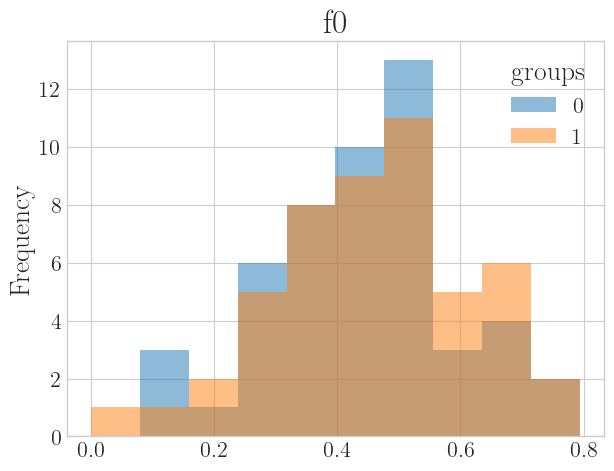

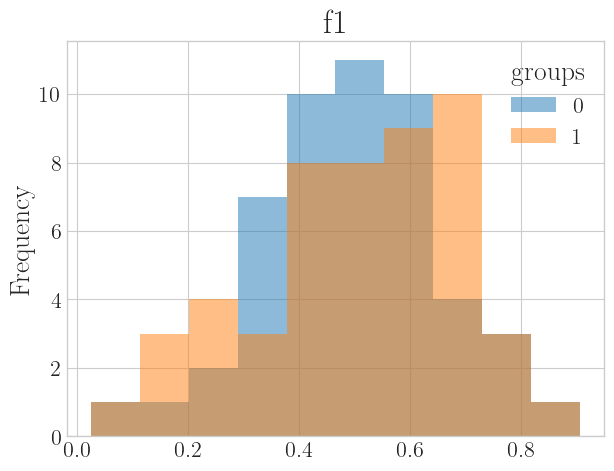

In [10]:
print("Original classes:\n", df.groupby(["groups", y]).size())
print("Predicted classes:\n", df.groupby(["groups", model.predict(df)]).size())
df.pivot(columns="groups")["f0"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f0")
df.pivot(columns="groups")["f1"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f1")

In [11]:
df.min(), df.max()

(f0        0.000000
 f1        0.025097
 groups    0.000000
 dtype: float64,
 f0        0.794077
 f1        0.905666
 groups    1.000000
 dtype: float64)

In [12]:
# Define the necessary components to run simulation
recourse = DiCE(model, categorical=["groups"], immutable=["groups"], random_state=RNG_SEED)
recourse.set_actions(df)
recourse.action_set_.lb = [0, 0, 0]
recourse.action_set_.ub = [1, 1, 1]

environment = CDAEnvironment(
    X=df,
    recourse=recourse,
    data_source_func=env_biased_data_generator,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="continuous_constant",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(20)

/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "
100%|████████████| 90/90 [04:35<00:00,  3.06s/it]


CDAEnvironment(X=          f0        f1  groups
0   0.794077  0.581921       1
1   0.499063  0.520119       1
2   0.465055  0.466104       1
3   0.434207  0.388234       1
4   0.137278  0.482075       0
..       ...       ...     ...
95  0.131034  0.349407       0
96  0.448763  0.285552       0
97  0.000000  0.717068       1
98  0.312785  0.409450       0
99  0.220909  0.690816       1

[100 rows x 3 columns],
               adaptation=0.8, behavior_function='continuous_constant',
               data_source_func=<function env_biased_data_generator at 0x7f28ace7fa30>,
               growth_rate=10, growth_rate_type='absolute',
               recourse=DiCE(categorical=['groups'], immutable=['groups'],
                             model=IgnoreGroupLR(ignore_feature=['groups']),
                             threshold=0.6943160566940274),
               threshold=10)

In [13]:
environment.recourse.model.predict_proba(pd.DataFrame([[1.,1.,1]], columns=df.columns))[0,1], environment.recourse.threshold

(0.8246999132781357, 0.6943160566940274)

In [14]:
environment.model_._get_X(pd.DataFrame([[1,1,1]], columns=df.columns))

,f0,f1
0,1,1


In [15]:
environment.get_score_threshold()

0.6873868538845143

# Visualization and analysis

In [16]:
from matplotlib.colors import ListedColormap
environment.plot._favorable = ListedColormap(["#40b27f", "green"])
environment.plot._unfavorable = ListedColormap(["#51a3ef", "blue"])
environment.plot._previous = ListedColormap(["#be4d65", "red"])

<Axes: title={'center': 'Population scores over 21 time steps'}, xlabel='Step', ylabel='Score'>

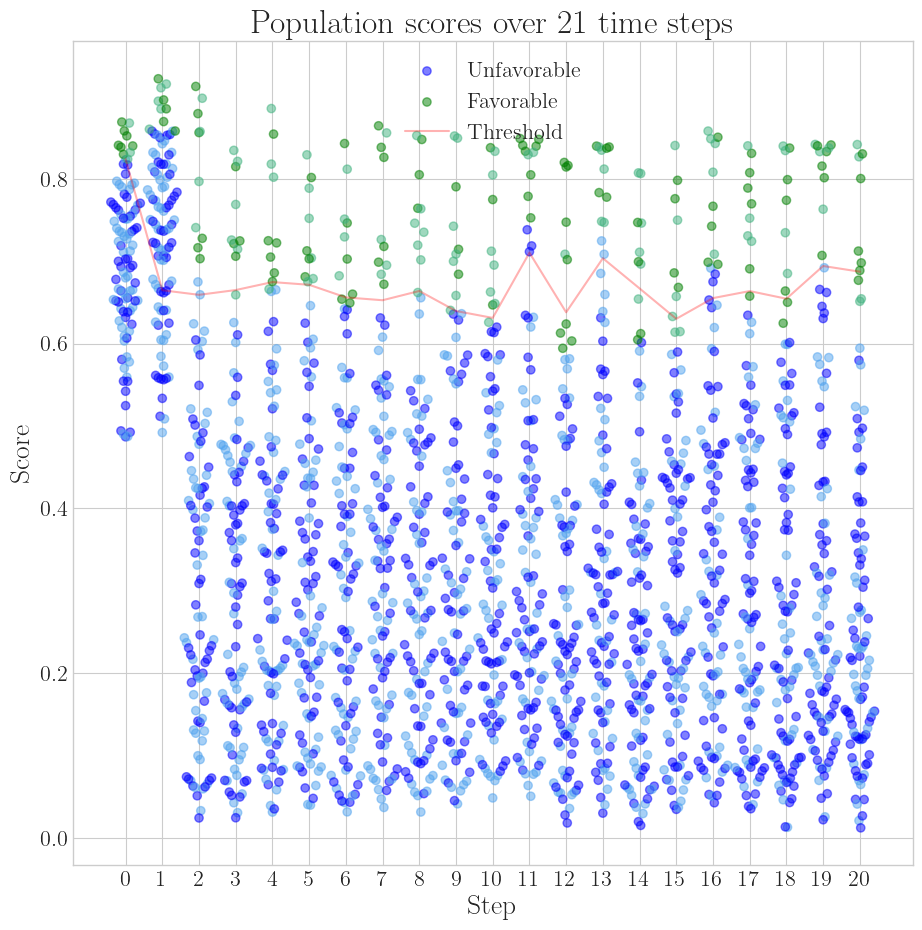

In [17]:
environment.plot.agent_scores(color_feature="groups")

In [18]:
environment.metadata_[0]["model"].coef_, environment.metadata_[5]["model"].coef_, environment.metadata_[5]["model"].coef_

(array([[2, 2]]),
 array([[6.15546801, 0.81162035]]),
 array([[6.15546801, 0.81162035]]))

<Axes: title={'center': 'Population at t=10'}, xlabel='Component 1', ylabel='Component 2'>

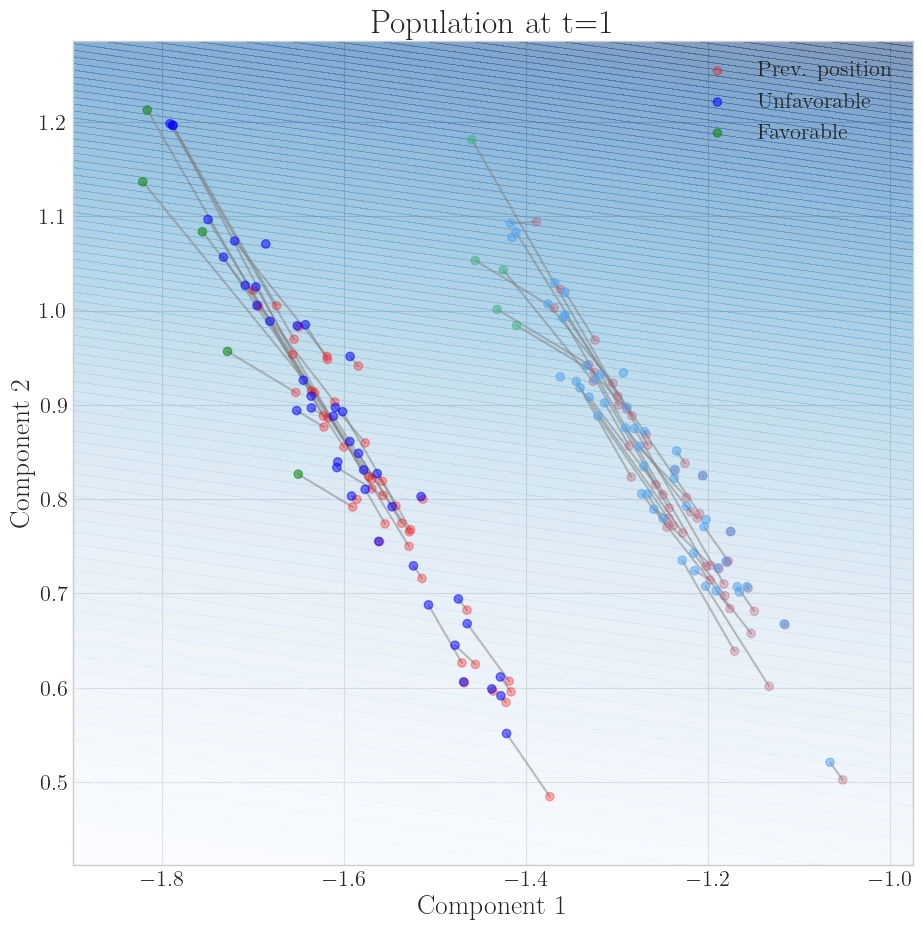

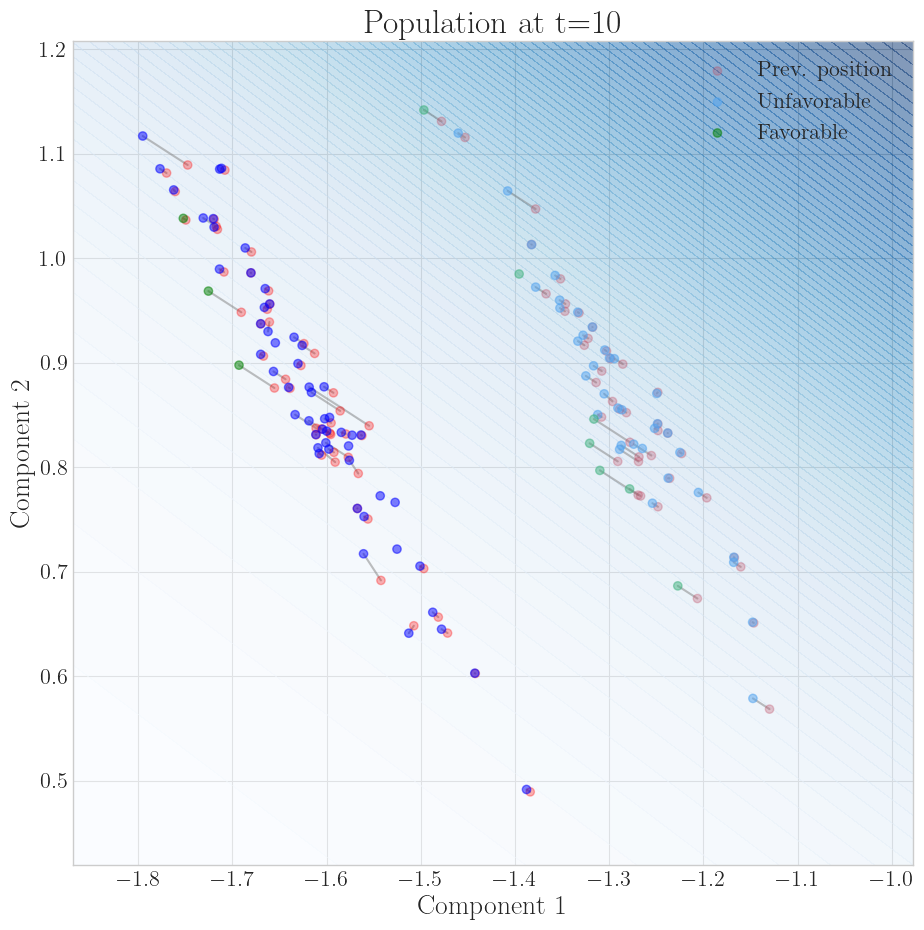

In [19]:
environment.plot.scatter(1, color_feature="groups")
environment.plot.scatter(10, color_feature="groups")

In [20]:
fairness_metrics(environment)

,time_for_recourse_disparity,avg_recourse_reliability_disparity,EO
groups,,,
0,1.048562,0.966619,1.000263


# Draft code

In [21]:
BIAS_FACTOR

0

In [22]:
df

,f0,f1,groups
0,0.794077,0.581921,1
1,0.499063,0.520119,1
2,0.465055,0.466104,1
3,0.434207,0.388234,1
4,0.137278,0.482075,0
...,...,...,...
95,0.131034,0.349407,0
96,0.448763,0.285552,0
97,0.000000,0.717068,1
98,0.312785,0.409450,0


In [23]:
counts = Counter(df["groups"])

In [24]:
Counter(environment.X_.groups)

Counter({1: 61, 0: 39})

In [25]:
Counter(environment.get_all_agents().groups)

Counter({1: 167, 0: 133})